In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.visualization import *
from decode_fish.funcs.predict import predict

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

# Training

Load base config

In [4]:
cfg = OmegaConf.load('config/train.yaml')

Make dataset specific changes

In [5]:
cfg.output.project = 'msp300_smFISH'
cfg.run_name ='msp300_1'

cfg.data_path.image_path = cfg.base_dir + '/datasets/CodFish/smFISH_data_Titlow/msp300_smFISH_3.tif'
cfg.data_path.psf_path = None

cfg.PSF.psf_extent_zyx = [21,21,21]
cfg.PSF.gauss_radii = [2.,1.0,1.0]

cfg.evaluation.crop_sl = 's_[:,:,100:200,400:500]'
cfg.evaluation.px_size_zyx =  [100,100,100]

cfg.bg_estimation.smoothing_filter_size = 5
cfg.foci.n_foci_avg = 2
cfg.microscope.scale = 1000

cfg.prob_generator.low = 0.0002
cfg.prob_generator.high = 0.001

We load the image and use a simple heuristic function to estimate the noise scale. Here we use the 99% lowest intensity values
to exlude the majority of the signal. Set the percentile value to obtain a range like below. If it is to high (e.g. 99.9 in this example) you will see a long tail with high intensities, if it is to low, e.g. 95 you will get something that looks like a truncated Gaussian.

36.22971335158533


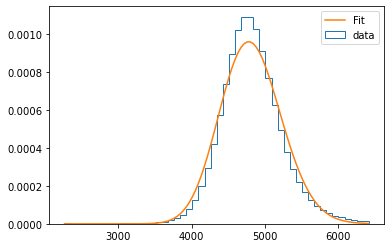

In [6]:
img = load_tiff_image(cfg.data_path.image_path)
bg_est = hydra.utils.instantiate(cfg.bg_estimation)(img)
theta = estimate_noise_scale(img, bg_est, percentile=99)
print(theta)

In [7]:
cfg.noise.theta = float(theta)

Here we plot maximum intensity projections of the whole volume and the sub volume given by evaluation.crop_sl.  
The localizations for this sub volume are tracked during training to evaluate progress. You should chose an interesting (e.g. dense) region.

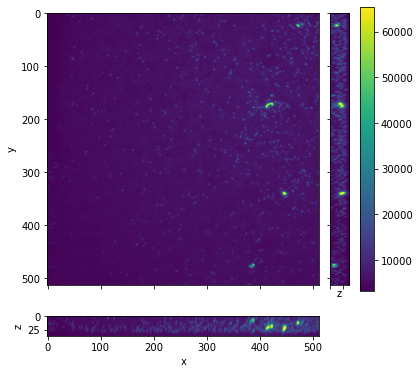

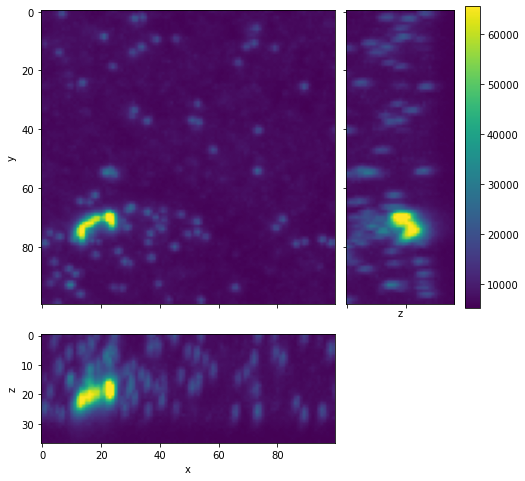

In [8]:
_ = plot_3d_projections(img, size=5, proj_func=np.max)
sl = eval(cfg.evaluation.crop_sl,{'__builtins__': None},{'s_': np.s_})
_ = plot_3d_projections(img[sl[:]], size=5)

Create the dataloader which samples random subsets from the recorded volumes and generates simulated data that we use for training.  
For visualization purposes it is often better to not sample foci as they distort the colorscale.

In [10]:
n_foci = cfg.foci.n_foci_avg
cfg.foci.n_foci_avg = 0
img_3d, decode_dl = get_dataloader(cfg)
psf, noise, micro = load_psf_noise_micro(cfg)
cfg.foci.n_foci_avg = n_foci

Crop size larger than volume in at least one dimension. Crop size changed to (37, 48, 48)
1 volumes


This function allows you to visually compare the recorded data and the simulations generated with the given config.  
For each sample we plot a slice from the input volume and from a simulated training volume as well as the estimated background.  
In the second row we compare maximum intensity projections.  

Adjust the microscope.scale and PSF.gauss_radii until you achieve a rough match in intensities and the PSF shape.  
You don't have to get this exactly right as these values get automatically fine tuned during training.
It is totally fine if average density of emitters in the simulations is higher than in the recordings.

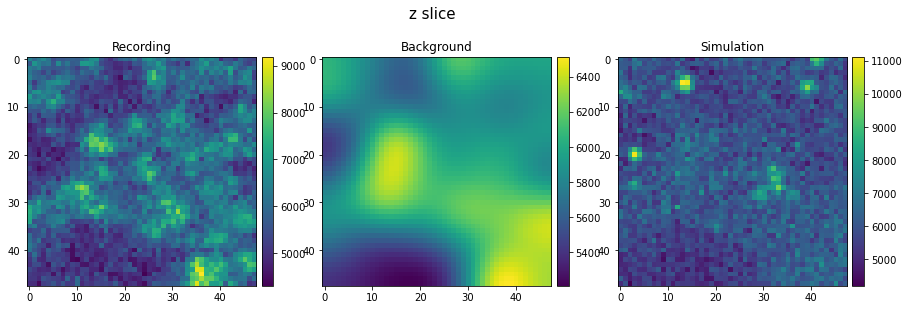

AttributeError: 'NoneType' object has no attribute 'suptitle'

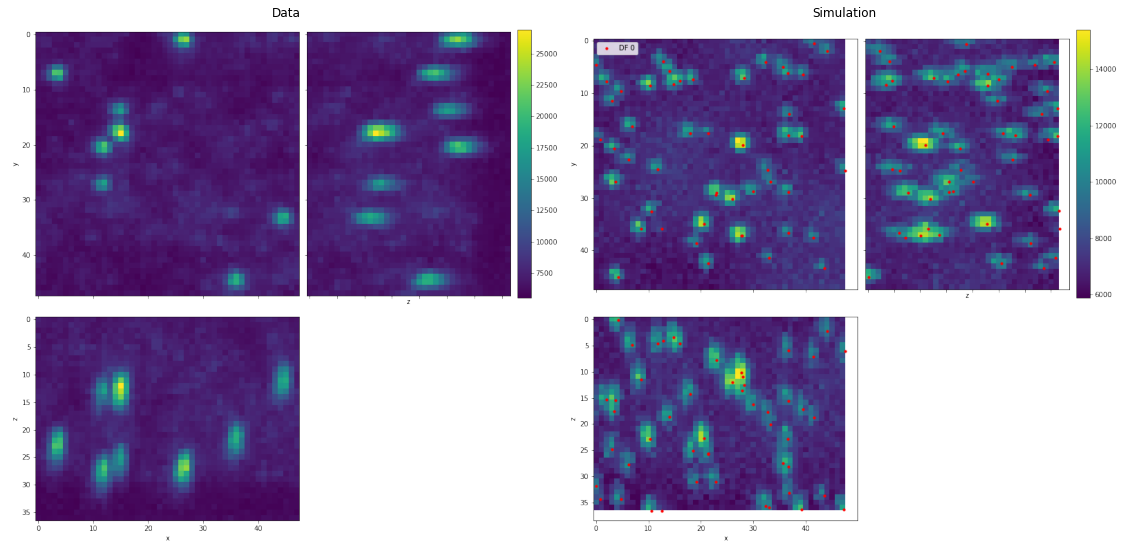

In [11]:
get_simulation_statistics(decode_dl, micro, **cfg.intensity_dist, int_threshold=10, samples=3)

Store the config as an experiment

In [ ]:
OmegaConf.save(cfg, f'config/experiment/{cfg.run_name}.yaml')
cfg.run_name

The config file is all you need to train your model. There is a couple of options.  
* You can load the config in the nbs/13_train.ipynb notebook and run all cells. This will continuously produce plots that let you track the training progress.  
* The recommended method is to execute the exeriment in your terminal: "python decode_fish/train.py +experiment=msp300_1"  If you enabled wandb tracking you will get a link for this run.
* You change parameters of your parameters in the command line. For example if you want to run training for more iterations you could execute:  
"python decode_fish/train.py +experiment=msp300_1 training.num_iters=50000 run_name=long_run"


Command to train a model on the gpu cluster

In [ ]:
home_dir = os.getenv("HOME")
f'bsub -gpu "num=1" -q gpu_any -o {home_dir}/logs/ofish.log -e {home_dir}/logs/efish.log {home_dir}/anaconda3/envs/decode2_dev/bin/python {home_dir}/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment={cfg.run_name}'

# Evaluation

In [ ]:
cfg = OmegaConf.load(f'config/experiment/msp300_1.yaml')

In [ ]:
model, post_proc, psf, micro, img_3d, decode_dl = load_all(cfg, False)
psf_init = get_gaussian_psf(cfg.PSF.psf_extent_zyx,cfg.PSF.gauss_radii)
psf_init = cpu(psf_init.psf_volume[0])
psf_vol = cpu(psf.psf_volume[0])

Plot mean projections of the PSF before and after optimizing it during training

In [ ]:
print(psf.get_com())
fig1,_ =plot_3d_projections(psf_init, proj_func=np.mean, size=3, display=False)
fig2,_ =plot_3d_projections(psf_vol, proj_func=np.mean, size=3, display=False)
_ = combine_figures([fig1,fig2],['Initial PSF','Learned PSF'], nrows=1, ncols=2, figsize=(20,10))

Sample random sub volumes and overlay them with predictions,  also shows the residuals between the input volume and the reconstruction from applying the microscope and PSF model to those predictions. Sometimes it looks like the network if missing obvious molecules. Often times this is because they are at the very edge of the volume. In that case they will be localized once you process the whole volume.

In [ ]:
eval_random_crop(decode_dl, model, post_proc, micro, samples=3)

If you are happy with the results you can run the network on whole volumes to get predictions. Be aware that a model will only produce good results on different recordings if the conditions with regards to PSF and intensity are similar as those used during training.

In [ ]:
# Chose paths of the tif files you wan't to process
image_paths = sorted(glob.glob(str(Path(cfg.data_path.image_path).parent)+'/msp300*.tif'))
image_paths

In order to run our network on arbitrarily large volumes we use a sliding window approach.  
**Warning: All leading dimensions (i.e. different channels) get flattened and treated as seperate 'frames'**

In [ ]:
pred_df = predict(model, post_proc, image_paths, window_size=[128, 256, 256], device='cuda')

The results provided as panda DataFrames which allow for easy indexing and saving/loading.

In [ ]:
preds_3 = pred_df[pred_df['frame_idx'] == 2]
preds_3_px = nm_to_px(preds_3, px_size_zyx=cfg.evaluation.px_size_zyx)
fig1, axes = plot_3d_projections(img_3d[0], display=False)
scat_3d_projections(axes, preds_3_px, s_fac=0.1)
fig2, axes = plot_3d_projections(img_3d[0], display=False)
combine_figures([fig1,fig2],[])

In [ ]:
# Save as csv
pred_df.to_csv('msp300_predictions.csv', index=False)
# Load from csv
pred_df = pd.read_csv('msp300_predictions.csv')

You can also perform the prediction with the predict.py script. Just provide the model path, the image path string, and the name for the output file.

In [ ]:
cfg.output.save_dir

In [ ]:
!python decode_fish/predict.py out_file='/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/msp300_predictions.csv' \
model_path='/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//models/fishcod/msp300_smFISH/nb_run/msp300_1/model.pkl' \
image_path='/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/datasets/CodFish/smFISH_data_Titlow/msp300*.tif'

In [ ]:
pred_df = pd.read_csv('msp300_predictions.csv')

This package does not provide any advanced visualization tools. 
A good outside option is napari (https://napari.org/)

To view the results in napari we store just the pixel coordinates as a numpy array:

In [ ]:
preds_3 = pred_df[pred_df['frame_idx'] == 2]
zyx_arr = nm_to_px(preds_3[['z','y','x']], cfg.evaluation.px_size_zyx).values
np.save('example/msp300_zyx',zyx_arr)

Load the volume into napari and execute the following commands in napari to add a point layer with the predictions:  

        p_zyx = np.load('example/msp300_zyx.npy')
        points_layer = viewer.add_points(p_zyx, size=2, face_color='green', n_dimensional=True)